In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_path='/content/drive/MyDrive/deep learning'
train_data_path=main_path+'/Google_Stock_Price_Train.xls'
test_data_path=main_path+'/Google_Stock_Price_Test.xls'

In [ ]:
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)


In [ ]:
train_data['Date'],test_data["Date"]=pd.to_datetime(train_data['Date']),pd.to_datetime(test_data['Date'])

In [ ]:
#there is issue with volumne data having , in its string
train_data['Volume'] = train_data['Volume'].str.replace(',', '').astype(float)
test_data['Volume'] = test_data['Volume'].str.replace(',', '').astype(float)
train_data['Close']=train_data['Close'].str.replace(",",'').astype(float)


train_data['Volume'] = pd.to_numeric(train_data['Volume'])
test_data['Volume'] = pd.to_numeric(test_data['Volume'])

In [ ]:
test_data.head(3)

,Date,Open,High,Low,Close,Volume
0,2017-01-03,778.81,789.63,775.80,786.14,1657300.0
1,2017-01-04,788.36,791.34,783.16,786.90,1073000.0
2,2017-01-05,786.08,794.48,785.02,794.02,1335200.0


In [ ]:
# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_test = scaler.transform(test_data[['Open', 'High', 'Low', 'Close', 'Volume']])


In [ ]:
def convert_data_into_array_of_days(input_data, N, M, feature_idx):
    X, y = [], []
    for i in range(len(input_data) - N - M + 1):
        X.append(input_data[i:i + N])  
        y.append(input_data[i + N:i + N + M, feature_idx])
    return np.array(X), np.array(y)

In [ ]:
# Define parameters
N, M = 30, 1  # 30 days input, 1 day prediction
feature_idx = 0  # Predicting 'Open' price

# Prepare data
X_open, y_open = convert_data_into_array_of_days(scaled_train, N, M, feature_idx)
X_open_train, X_open_val, y_open_train, y_open_val = train_test_split(X_open, y_open, test_size=0.2, random_state=42)


In [ ]:
# Build RNN model
def rnn_model_body(input_shape):
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=True,
                        input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=50,
                        return_sequences=True))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Predict the Open price of stock
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
input_shape = (X_open.shape[1], X_open.shape[2])
rnn_open_price_model = rnn_model_body(input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
rnn_open_price_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 30, 50)              │           2,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 30, 50)              │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,951 (50.59 KB)

 Trainable params: 12,951 (50.59 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1)
model_checkpoints = ModelCheckpoint(
    filepath=main_path+'/rnn_model_open_price.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
# Train the model
history_open = rnn_open_price_model.fit(
    X_open_train, y_open_train,
    validation_data=(X_open_val, y_open_val),
    epochs=1000,
    batch_size=32,
    callbacks=[model_checkpoints, early_stopping]
)

Epoch 1/1000
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6488
Epoch 1: val_loss improved from inf to 0.00611, saving model to /content/drive/MyDrive/deep learning/rnn_model_open_price.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.6242 - val_loss: 0.0061
Epoch 2/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2299
Epoch 2: val_loss did not improve from 0.00611
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.2294 - val_loss: 0.0078
Epoch 3/1000
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1532
Epoch 3: val_loss improved from 0.00611 to 0.00413, saving model to /content/drive/MyDrive/deep learning/rnn_model_open_price.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1531 - val_loss: 0.0041
Epoch 4/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1272
Epoch 4: val_loss did not improve from 0.00413
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1269 - val_loss: 0.0068
Epoch 5/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0892
Epoch 5: v

In [ ]:
N, M = 30, 1  # Use 30 past days to predict 1 day ahead
feature_idx = 0  # Predicting Open price

X_test, y_test = convert_data_into_array_of_days(scaled_test, N, M, feature_idx=feature_idx)

# Check shapes
print(f"X_test shape: {X_test.shape}")  # (samples, 30, 5)
print(f"y_test shape: {y_test.shape}")  # (samples, 1)

X_test shape: (0,)
y_test shape: (0,)


In [ ]:
scaled_test.shape

(20, 5)

In [ ]:
N = min(10, len(scaled_test) - M)
M = 1


X_test, y_test = convert_data_into_array_of_days(scaled_test, N, M, feature_idx=feature_idx)

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (10, 10, 5)
y_test shape: (10, 1)


In [ ]:
y_pred_scaled_test = rnn_open_price_model.predict(X_test)

# Check predicted shape
print(f"Predicted Test Shape: {y_pred_scaled_test.shape}")  # (samples, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
Predicted Test Shape: (10, 1)


In [ ]:
y_pred_scaled_test

array([[1.0054936 ],
       [1.0049492 ],
       [1.0005113 ],
       [0.99910235],
       [1.0004346 ],
       [1.0062574 ],
       [1.0138899 ],
       [1.0171646 ],
       [1.0185041 ],
       [1.0152675 ]], dtype=float32)

In [ ]:
# Inverse transform predictions
y_pred_original_test = scaler.inverse_transform(
    np.concatenate([y_pred_scaled_test, np.zeros((y_pred_scaled_test.shape[0], 4))], axis=1)
)[:, feature_idx]  # Extract the column for the specific feature (e.g., Open price)

# Inverse transform actual test values
y_test_original = scaler.inverse_transform(
    np.concatenate([y_test, np.zeros((y_test.shape[0], 4))], axis=1)
)[:, feature_idx]  # Extract the column for the specific feature

In [ ]:
compare_table = pd.DataFrame({
    "Actual": y_test_original.flatten(),
    "Predicted": y_pred_original_test.flatten()
})

print(compare_table)

   Actual   Predicted
0  805.81  819.633162
1  805.12  819.340498
2  806.91  816.954848
3  807.25  816.197461
4  822.30  816.913644
5  829.62  820.043736
6  837.81  824.146659
7  834.71  825.906996
8  814.66  826.627087
9  796.86  824.887193


In [ ]:
mse_test = mean_squared_error(y_test_original, y_pred_original_test)
rmse_test = mse_test ** 0.5
mae_test = mean_absolute_error(y_test_original, y_pred_original_test)

print(f"Test MSE: {mse_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test MAE: {mae_test}")

Test MSE: 188.78905435604298
Test RMSE: 13.740052924062665
Test MAE: 12.445921474456782


In [ ]:
y_test_original.shape, y_pred_original_test.shape

((10,), (10,))

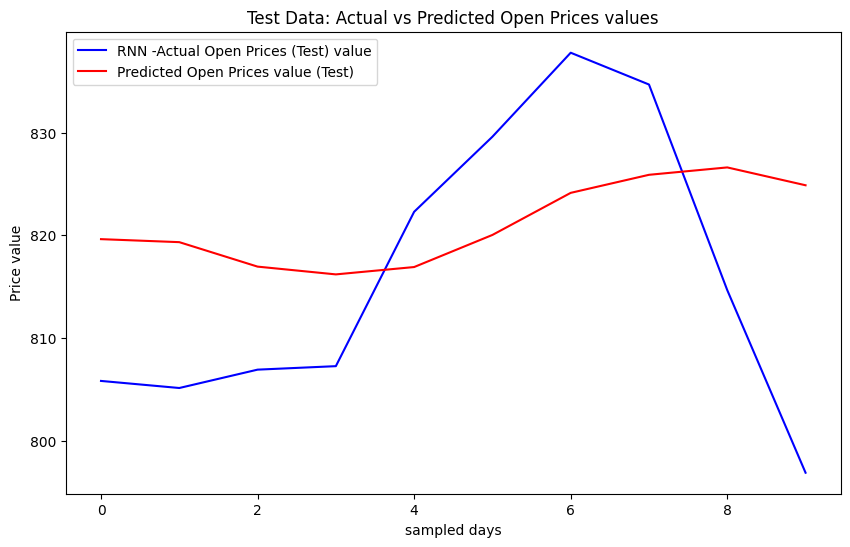

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="RNN -Actual Open Prices (Test) value", color='blue')
plt.plot(y_pred_original_test, label="Predicted Open Prices value (Test)", color='red')
plt.title("Test Data: Actual vs Predicted Open Prices values")
plt.xlabel("sampled days")
plt.ylabel("Price value")
plt.legend()
plt.show()

In [ ]:
def model_eval(y_true_scaled, y_pred_scaled, feature_idx, scaler):
    y_pred_original = scaler.inverse_transform(
        np.concatenate([y_pred_scaled, np.zeros((y_pred_scaled.shape[0], 4))], axis=1)
    )[:, feature_idx]

    # Inverse transform true values
    y_true_original = scaler.inverse_transform(
        np.concatenate([y_true_scaled, np.zeros((y_true_scaled.shape[0], 4))], axis=1)
    )[:, feature_idx]

    # Calculate metrics
    mse = mean_squared_error(y_true_original, y_pred_original)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_true_original, y_pred_original)

    return {"MSE": mse, "RMSE": rmse, "MAE": mae}

In [ ]:
# Predict on training data
y_pred_scaled_train = rnn_open_price_model.predict(X_open_train)

# Predict on validation data
y_pred_scaled_val = rnn_open_price_model.predict(X_open_val)

# Predict on test data
y_pred_scaled_test = rnn_open_price_model.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Output of train  {'MSE': 1897.836304960228, 'RMSE': 43.56416308114076, 'MAE': 39.76683864755319}
   Actual   Predicted
0  775.48  822.887381
1  717.06  773.689275
2  438.41  474.698629
3  498.63  533.386788
4  584.99  621.185207
5  581.75  621.321638
6  399.05  442.296789
7  539.92  582.853094
8  528.55  587.913276
9  766.69  809.911387


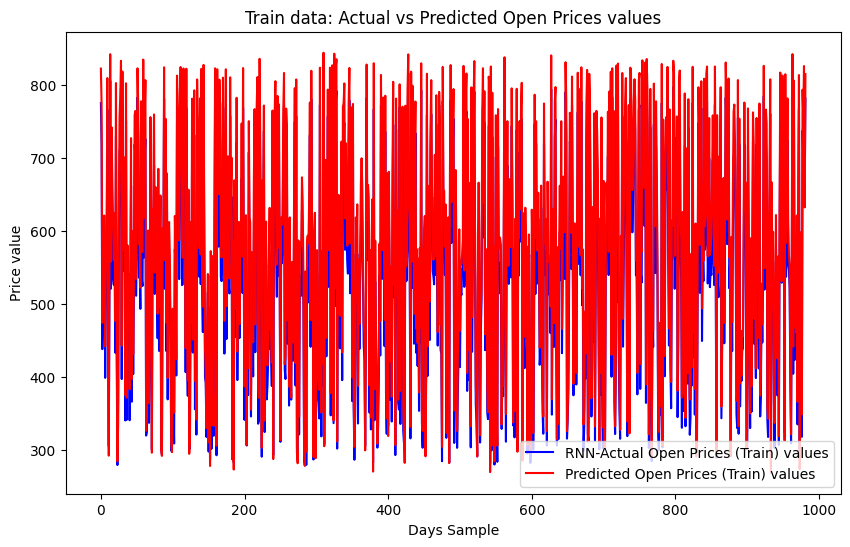

In [ ]:
y_pred_original_train = scaler.inverse_transform(
    np.concatenate([y_pred_scaled_train, np.zeros((y_pred_scaled_train.shape[0], 4))], axis=1)
)[:, feature_idx]

y_train_original = scaler.inverse_transform(
    np.concatenate([y_open_train, np.zeros((y_open_train.shape[0], 4))], axis=1)
)[:, feature_idx]

outputs_train=model_eval(y_open_train, y_pred_scaled_train, feature_idx, scaler)
print("Output of train ",outputs_train)

compare_train_table = pd.DataFrame({
    "Actual": y_train_original.flatten(),
    "Predicted": y_pred_original_train.flatten()
})

print(compare_train_table.head(10))

plt.figure(figsize=(10, 6))
plt.plot(y_train_original, label="RNN-Actual Open Prices (Train) values", color='blue')
plt.plot(y_pred_original_train, label="Predicted Open Prices (Train) values", color='red')
plt.title("Train data: Actual vs Predicted Open Prices values")
plt.xlabel("Days Sample")
plt.ylabel("Price value")
plt.legend()
plt.show()


Output of validation  {'MSE': 1924.0445153883963, 'RMSE': 43.863931827737424, 'MAE': 39.60805921945751}
   Actual   Predicted
0  526.35  557.259005
1  577.83  637.060854
2  378.12  429.373311
3  515.76  557.995437
4  777.85  827.035418
5  595.10  666.124189
6  582.16  622.918148
7  516.64  585.778315
8  287.07  294.705667
9  335.80  369.246395


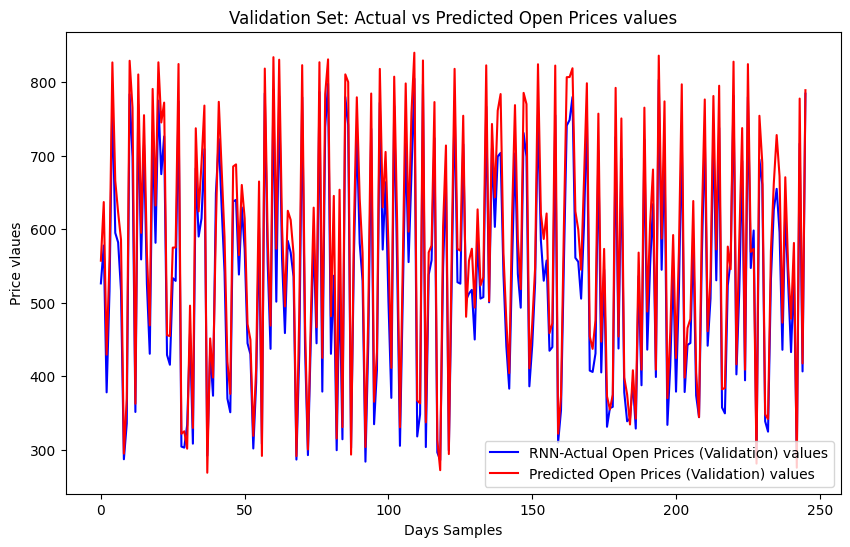

In [ ]:
y_pred_original_val = scaler.inverse_transform(
    np.concatenate([y_pred_scaled_val, np.zeros((y_pred_scaled_val.shape[0], 4))], axis=1)
)[:, feature_idx]

y_val_original = scaler.inverse_transform(
    np.concatenate([y_open_val, np.zeros((y_open_val.shape[0], 4))], axis=1)
)[:, feature_idx]

outputs_val=model_eval(y_open_val, y_pred_scaled_val, feature_idx, scaler)
print("Output of validation ",outputs_val)

compare_val_table = pd.DataFrame({
    "Actual": y_val_original.flatten(),
    "Predicted": y_pred_original_val.flatten()
})

print(compare_val_table.head(10))

plt.figure(figsize=(10, 6))
plt.plot(y_val_original, label="RNN-Actual Open Prices (Validation) values", color='blue')
plt.plot(y_pred_original_val, label="Predicted Open Prices (Validation) values", color='red')
plt.title("Validation Set: Actual vs Predicted Open Prices values")
plt.xlabel("Days Samples")
plt.ylabel("Price vlaues")
plt.legend()
plt.show()
